In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

# Nastro pro vizualizaci a statistiku

In [2]:
class I_Optimizer:
    def __init__(self):
        # callback pro reset (reference_soma)
        self.reset_callback = []
        # callback pro iteraci (reference_soma, particles, gbest_pos, gbest_value)
        self.iteration_callback = []
    
class I_Individual:
    def get_position(self):
        return None

class PopulationState:
    def __init__(self, pop: list[I_Individual], gbest_pos, gbest_value):
        self.population= []
        for p in pop:
            self.population.append(p.get_position().copy())
        self.gbest_pos = gbest_pos
        self.gbest_value = gbest_value

class Visualizer:
    def __init__(self):
        self.population_states = {}

    def bind(self, optimizer: I_Optimizer):
        optimizer.reset_callback.append(self.__reset_callback)
        optimizer.iteration_callback.append(self.__iteration_callback)

    def __reset_callback(self, optimizer: I_Optimizer):
        self.population_states[optimizer] = None

    def __iteration_callback(self, optimizer: I_Optimizer, population, gbest_pos, gbest_value):
        if self.population_states[optimizer] is None:
            self.population_states[optimizer] = []
        self.population_states[optimizer].append(PopulationState(population, gbest_pos, gbest_value))

    def __split_iter_range(self, end, count):
        iters = []
        krok = (end - 0) / (count - 1)
        for i in range(count - 1):
            hodnota = round(i * krok)
            iters.append(hodnota)
        iters.append(end)
        return iters

    def plot_ps_states(self, optimizer: I_Optimizer, count, r_min: float, r_max: float):
        if type(count) == int:
            row_count = math.ceil(count / 4)
            iters = self.__split_iter_range(end=len(self.population_states[optimizer])-1, count=count)
        else:
            iters = count
            count = len(count)
            row_count = math.ceil(count / 4)

        fig, axes = plt.subplots(row_count, min(count, 4), figsize=(19, (18/4)*row_count))
        for i in range(count):
            current_row = int(i/4)
            if row_count > 1:
                self.plot_ps_state(axes[current_row, i % 4], optimizer, iters[i], r_min, r_max)
            else:
                self.plot_ps_state(axes[i % 4], optimizer, iters[i], r_min, r_max)
        plt.show()

    def plot_ps_state(self, axes, optimizer: I_Optimizer, iteration: int, r_min: float, r_max: float):
        state = self.population_states[optimizer][iteration]
        positions = np.array([pos for pos in state.population])
        axes.scatter(positions[:, 0], positions[:, 1], color='r', marker='o', label='Particles')
        axes.scatter(state.gbest_pos[0], state.gbest_pos[1], color='g', marker='*', label='gBest')
        axes.set_title(f'Iteraton = {iteration}')
        axes.set_xlabel('X')
        axes.set_ylabel('Y')
        axes.set_xlim(r_min, r_max)
        axes.set_ylim(r_min, r_max)
        axes.legend()

    def plot_convergence_graph(self, optimizer: I_Optimizer):
        plt.figure(figsize=(10, 5))
        states = self.population_states[optimizer]
        curve = [s.gbest_value for s in states]
        plt.semilogy(curve)
        plt.xlabel('Iteration')
        plt.ylabel('gBest Value')
        plt.title('Convergence graph')
        plt.show()

In [3]:
class Range:
    def __init__(self, min: float, max: float) -> None:
        self.min = min
        self.max = max

    def size(self):
        return self.max - self.min

# Jedinec populace

In [4]:
class Individual(I_Individual):
    def __init__(self, dim: int, range: Range):
        """
        Trida pro jedince

        Parametry:
            dim - dimenze jedince
            range - rozsah hodnot reseni problemu
        """
        self.position = np.random.uniform(range.min, range.max, size=dim)
        self.value = float('inf')
        self.personal_best_pos = self.position.copy()
        self.personal_best_val = float('inf')
        self.range = range

    def get_position(self):
        """
        Navrati aktualni pozici jedince
        """
        return self.position
    
    def get_value(self):
        """
        Navrati aktualni hodnotu jedince
        """
        return self.value
    
    def get_personal_best_position(self):
        """
        Navrati nejlepsi nalezenou pozici jedince (pBest - position)
        """
        return self.personal_best_pos

    def get_personal_best_value(self):
        """
        Navrati nejlepsi nalezenou hodnotu jedince (pBest - fitness)
        """
        return self.personal_best_val

    def set_position(self, new_pos):
        """
        Nastavi jedinci novou pozici, nova pozice je hodnotou automaticky omezena zvolenym rozsahem.

        Parametry:
            position - nova pozice jedince
        """
        new_pos = np.clip(new_pos, self.range.min, self.range.max)
        self.position = new_pos

    def reset_personal_best(self):
        """
        Resetuje nejlepsi nalezenou pocizi
        """
        self.personal_best_pos = self.position
        self.personal_best_val = self.value

    def set_position_to_personal_best(self):
        """
        Aktualni pozici a hodnote priradi hodnoty "personal best" drive nejlepsi nalezene pozice
        """
        self.position = self.personal_best_pos
        self.value = self.personal_best_val   

    def update_fitness(self, obj_func):
        """
        Aktualizuje nejlepsi pozici jedince. Pokud je aktualni pozice lepe ohodnocena nez dosavadni nejlepsi pozice, tak je prepsana novou.

        Parametry:
            obj_func - funkce optimalizaniho problemu (urcuje kvalitu aktualni pozice)
        """
        self.value = obj_func(self.position)
        if self.value < self.personal_best_val:
            self.personal_best_val = self.value
            self.personal_best_pos = self.position.copy()

# Populace

In [5]:
class Population:
    def __init__(self, dim: int, nindividual: int, range: Range) -> None:
        """
        Trida pro populaci jedincu

        Parametry:
            dim - dimenze castic
            nparticles - pocet jedincu
            range - rozsah hodnot reseni
            topology - topologie 
        """
        self.dim = dim
        self.nindividual = nindividual
        self.range = range
        self.propts = {}
        self.random_init(None)

    def setProperty(self, name: str, value):
        """
        Nastavi libovolnou konfigurace pro roj castic
        """
        self.propts[name] = value

    def random_init(self, obj_func):
        """
        Nahodna inicializace/reinicializace roje castic

        Parametry:
            obj_func - funkce optimalizovaneho problemu (urcuje kvalitu aktualni pozice)
        """
        self.global_best_individual = None
        self.individuals = [Individual(self.dim, self.range)
                          for _ in range(self.nindividual)]
        if obj_func is not None:
            for individual in self.individuals:
                individual.update_fitness(obj_func)
                self.update_global_best_with_one_indivial(individual)

    def get_individuals(self):
        """
        Navrati vsechny jedince populace
        """
        return self.individuals

    def get_range(self):
        """
        Navrati rozsah hodnot reseni
        """
        return self.range

    def get_dim(self):
        """
        Navrati dimenzi reseneho problemu
        """
        return self.dim

    def get_global_best(self):
        """
        Navrati nejlepsiho jedince populace
        """
        return self.global_best_individual

    def update_global_best_with_one_indivial(self, individual: Individual):
        """
        Obnovi novou globalne nejlepsi hodnotu

        Parametry:
            individual - jedinec jejiz personalni nejlepsi hodnota muze byt nastavena jako globalne nejlepsi
        """
        if self.global_best_individual == None:
            self.global_best_individual = individual   
        elif individual.get_value() < self.global_best_individual.get_value():
            self.global_best_individual = individual

# SOMA algoritmus

In [6]:
MIGRATION_ALL_TO_ONE = 'all-to-one'
MIGRATION_ALL_TO_ALL = 'all-to-all'

class SOMA(I_Optimizer):
    def __init__(self, population: Population):
        super().__init__()
        """
        Třída pro SOMA algoritmus

        Parametry:
            population - Reference na popilaci
        """
        # reference na populaci
        self.population = population
        self.evaluation_cnt = 0


    def set_obj_func(self, obj_func):
        """
        Priradi algoritmu optimalizovanou funkci

        Parametry:
            obj_func - Funkce ktera bude optimalizovana
        """
        self.obj_func = obj_func


    def get_population(self) -> Population:
        """
        Navrati populaci
        """
        return self.population
    

    def __invokeResetCallback(self):
        for callback in self.reset_callback:
            callback(self)


    def __invokeIterationCallback(self):
        for callback in self.iteration_callback:
            gBest = self.population.get_global_best()
            callback(self, self.population.get_individuals(), gBest.get_position().copy(), gBest.get_value())

    def __generatePRTVector(self, prt: float, dim: int):
        # nahodna generace podle zakladniho pravidla
        prt_vector = np.array([1.0 if random.random() < prt else 0.0 for _ in range(self.population.get_dim())])
        # pokud je vektor cely 0, tak nahodne vlozi 1
        if np.sum(prt_vector) == 0.0:
            index_to_set_one = random.randint(0, len(prt_vector) - 1)
            prt_vector[index_to_set_one] = 1.0
        return prt_vector

    def __migrate_all_to_one(self, prt: float, step: float, path_len: float):
        """
        Provadi migraci vsech jedincu k nejlepsimu jedinci (All-To-One).

        Parametry:
            prt - prah pro mutaci (migrace), doporucene: 0.3
            step - velikost kroku, doporucene: 0.11, 0.22, 0.33, ..
            path_len - delke cesty (prozkoumavane oblasti), doporucene: 2.0 - 3.0
        """
        gBest = self.population.get_global_best()

        for individual in self.population.get_individuals():
            # napocita se pro leadera (nejlepsi aktualni reseni)
            if individual == gBest:
                continue

            # zalohuje si pocatecni pozici jedince + resetuje personal best
            base_position = individual.get_position().copy()
            individual.reset_personal_best()

            # vypocet ucelove funkce v nahodnem smeru ve vsech krocich
            t = step
            while t <= path_len:
                # nahodna volba smeru (perturbacni vektor)
                prt_vector = self.__generatePRTVector(prt, self.population.get_dim())
                # vypocet pozice
                individual.set_position(base_position + (gBest.get_position() - individual.get_position()) * t * prt_vector)
                individual.update_fitness(self.obj_func)
                self.evaluation_cnt += 1 # pro diagnostiku
                t += step
            
            # nastavi jedinci nejlepsi pozici ze vsech kroku rozsahu (provadi se za behu)
            individual.set_position_to_personal_best()


    def __migrate_all_to_all(self, prt: float, step: float, path_len: float):
        """
        Provadi migraci vsech jedincu ke všem ostatnim navzajem (All-To-All).

        Parametry:
            prt - prah pro mutaci (migrace), doporucene: 0.3
            step - velikost kroku, doporucene: 0.11, 0.22, 0.33, ..
            path_len - delke cesty (prozkoumavane oblasti), doporucene: 2.0 - 3.0
        """

        # reset personal best pro vsechny jedince
        for individual in self.population.get_individuals():
            individual.reset_personal_best()

        # migracni algoritmus all-to-all
        for i1, individual_1 in enumerate(self.population.get_individuals()):
            for i2, individual_2 in enumerate(self.population.get_individuals()):
                # jedinec 1 a 2 musi byt jini, nesmi jit o jednoho a toho sameho
                if i1 == i2:
                    continue

                # zalohuje si pocatecni pozici jedince 1
                base_position = individual_1.get_position().copy()

                # vypocet ucelove funkce v nahodnem smeru ve vsech krocich
                t = step
                while t <= path_len:
                    # nahodna volba smeru (perturbacni vektor)
                    prt_vector = self.__generatePRTVector(prt, self.population.get_dim())
                    # vypocet pozice
                    individual_1.set_position(base_position + (individual_2.get_position() - individual_1.get_position()) * t * prt_vector)
                    individual_1.update_fitness(self.obj_func)
                    self.evaluation_cnt += 1 # pro diagnostiku
                    t += step
                
                # obnoveni puvodni pozice jedince 1
                individual_1.set_position(base_position)
        
        # vsem jedinucem nastavi nejlepsi nalezene pozice (provede se az uplne na konci)
        for individual in self.population.get_individuals():
            individual.set_position_to_personal_best()


    def optimize(self, max_migrations: int, prt: float, step: float, path_len: float, migration_type=MIGRATION_ALL_TO_ONE):
        """
        Optimalizuje problem pomoci SOMA algoritmu

        Parametry:
            max_migrations - Maximalni pocet migraci populace
            prt - prah pro mutaci (migrace), doporucene: 0.3
            step - velikost kroku, doporucene: 0.11, 0.22, 0.33, ..
            path_len - delke cesty (prozkoumavane oblasti), doporucene: 2.0 - 3.0
            migration_type - typ migrace (MIGRATION_ALL_TO_ONE nebo MIGRATION_ALL_TO_ALL)
        """
        
        # zavola callback pro reset
        self.__invokeResetCallback()
        
        # nahodna inicializace
        self.population.random_init(self.obj_func)


        # hlavni cast algoritmu
        for _ in range(max_migrations):
            # zavola callback pro odeslani aktualniho stavu
            self.__invokeIterationCallback()

            # Aktualizace globalne nejlepsiho jedince (jen pokud je to vyzadovano)
            if migration_type == MIGRATION_ALL_TO_ONE:
                for individual in self.population.get_individuals():
                    self.population.update_global_best_with_one_indivial(individual)

            # Migrace populace jedincu
            if migration_type == MIGRATION_ALL_TO_ONE:
                self.__migrate_all_to_one(prt=prt, step=step, path_len=path_len)
            elif migration_type == MIGRATION_ALL_TO_ALL:
                self.__migrate_all_to_all(prt=prt, step=step, path_len=path_len)
            else:
                raise ValueError("Unsupported migration type!")


        # Aktualizace globalne nejlepsiho jedince (jen pokud je to vyzadovano)
        if migration_type == MIGRATION_ALL_TO_ALL:
            for individual in self.population.get_individuals():
                self.population.update_global_best_with_one_indivial(individual)

        # navrati gBest
        gBest = self.population.get_global_best()
        return gBest.get_position().copy(), gBest.get_value()

# Optimalizacni funkce

In [7]:
def sphere_function(x):
    return np.sum(x**2)

def rastrigins_function(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

def rosenbrock_function(x):
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def himmelblau(coords):
    x, y = coords[0], coords[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Nastaveni

In [8]:
CONFIG = {}

# dimenze reseneho problemu
CONFIG["DIM"] = 2

# rozsah hodnot reseni
CONFIG["RANGE"] = Range(min=-5.0, max=5.0)

# velikost kroku, doporucene: 0.11, 0.22, 0.33, ..
CONFIG["STEP"] = 0.22

# delke cesty (prozkoumavane oblasti), doporucene: 2.0 - 3.0
CONFIG["PATH_LEN"] = 3.0

# prah pro mutaci (migrace), doporucene: 0.3
CONFIG["PRT"] = 0.3

# maximalni pocet migraci
CONFIG["MAX_MIGRATIONS"] = 60

# Vizualizer

In [9]:
visualizer = Visualizer()

# Inicializace

In [10]:
# populace 1 (MIGRATION_ALL_TO_ONE)
pop1 = Population(dim=CONFIG["DIM"], nindividual=9*8+1, range=CONFIG["RANGE"])

soma1 = SOMA(population=pop1)
soma1.set_obj_func(himmelblau)
visualizer.bind(soma1)

# populace 2 (MIGRATION_ALL_TO_ALL)
pop2 = Population(dim=CONFIG["DIM"], nindividual=9, range=CONFIG["RANGE"])
pop2.setProperty("RING_SIZE", 2)

soma2 = SOMA(population=pop2)
soma2.set_obj_func(himmelblau)
visualizer.bind(soma2)

# Optimalizace

In [11]:
# spusteni optimalizacnich algoritmu pro obe populace
gBest1, gBestVal1 = soma1.optimize(
    max_migrations=CONFIG["MAX_MIGRATIONS"], 
    prt=CONFIG["PRT"], 
    step=CONFIG["STEP"], 
    path_len=CONFIG["PATH_LEN"], 
    migration_type=MIGRATION_ALL_TO_ONE)

gBest2, gBestVal2 = soma2.optimize(
    max_migrations=CONFIG["MAX_MIGRATIONS"], 
    prt=CONFIG["PRT"], 
    step=CONFIG["STEP"], 
    path_len=CONFIG["PATH_LEN"], 
    migration_type=MIGRATION_ALL_TO_ALL)

# Vysledky pro ALL TO ONE

[ALL TO ONE] Best solution: [3. 2.]
[ALL TO ONE] Solution value: 0.0
[ALL TO ONE] Number of evals:  56160


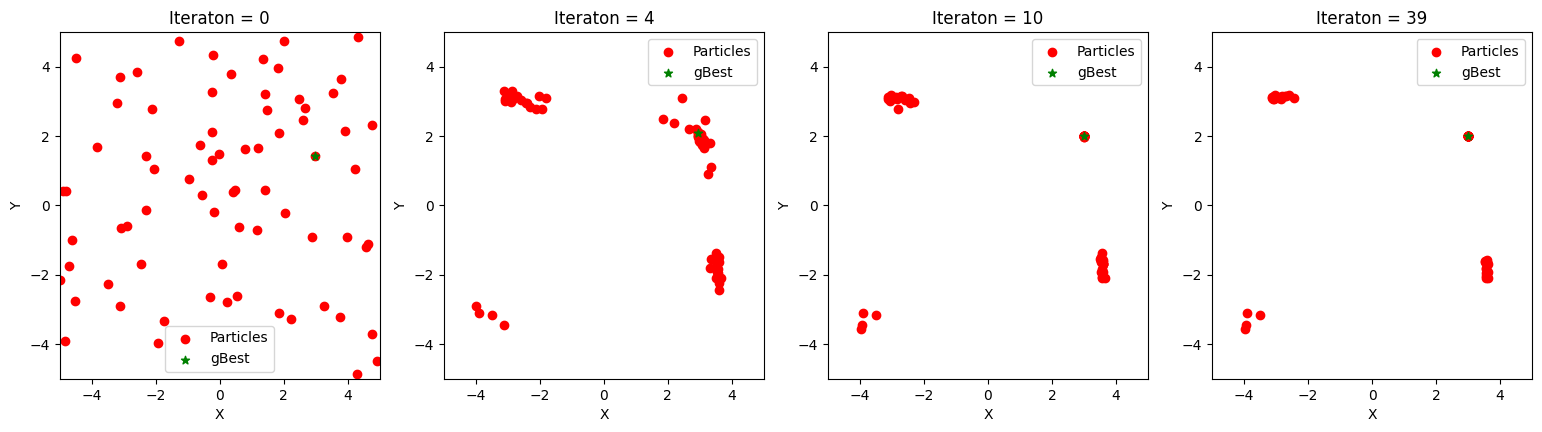

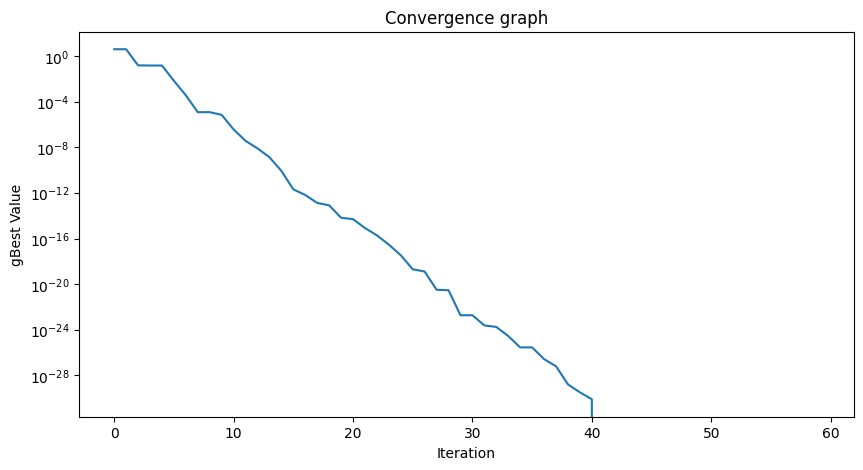

In [12]:
# vysledky 1
print("[ALL TO ONE] Best solution:", gBest1)
print("[ALL TO ONE] Solution value:", gBestVal1)
print("[ALL TO ONE] Number of evals: ", soma1.evaluation_cnt)
visualizer.plot_ps_states(optimizer=soma1, count=[0, 4, 10, 39], r_min=CONFIG["RANGE"].min, r_max=CONFIG["RANGE"].max)
visualizer.plot_convergence_graph(optimizer=soma1)

# Vysledky pro ALL TO ALL

[ALL TO ALL] Best solution: [-3.77931025 -3.28318599]
[ALL TO ALL] Solution value: 7.888609052210118e-31
[ALL TO ALL] Number of evals:  56160


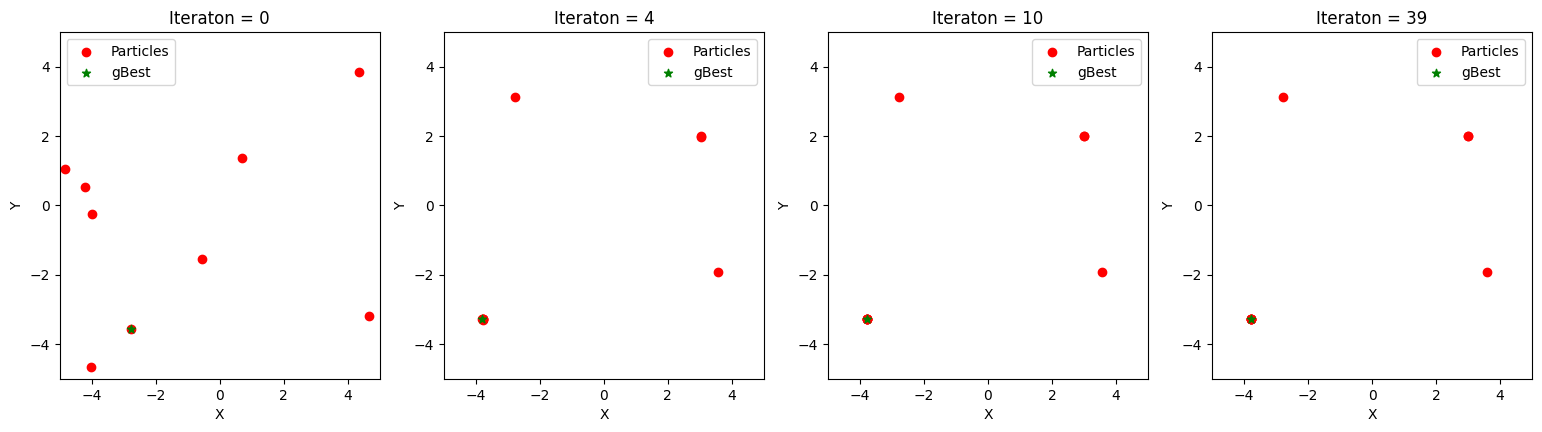

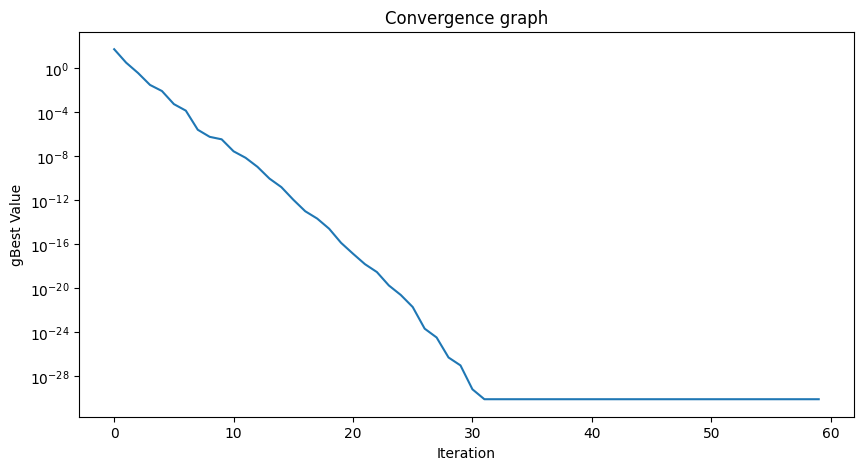

In [13]:
# vysledky 2
print("[ALL TO ALL] Best solution:", gBest2)
print("[ALL TO ALL] Solution value:", gBestVal2)
print("[ALL TO ALL] Number of evals: ", soma2.evaluation_cnt)
visualizer.plot_ps_states(optimizer=soma2, count=[0, 4, 10, 39], r_min=CONFIG["RANGE"].min, r_max=CONFIG["RANGE"].max)
visualizer.plot_convergence_graph(optimizer=soma2)

# 10D Rastrigin

[ALL TO ONE] Best solution: [-4.52849066e-09 -4.15910824e-09 -4.67577730e-10 -4.95596908e-10
  4.30325052e-11  3.19924844e-09 -7.71453425e-10 -3.82775408e-09
  8.73385029e-10 -4.52006755e-09]
[ALL TO ONE] Solution value: 0.0
[ALL TO ONE] Number of evals:  395200


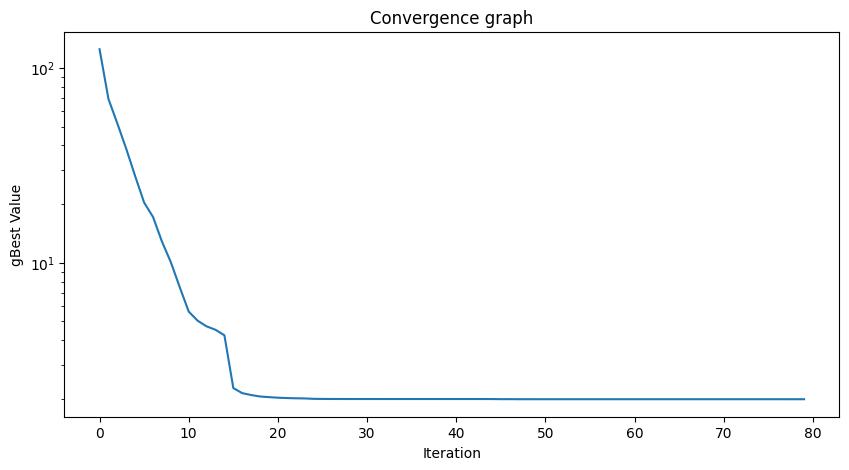

In [14]:
pop3 = Population(dim=10, nindividual=20, range=Range(-5.12, 5.12))

soma3 = SOMA(population=pop3)
soma3.set_obj_func(rastrigins_function)
visualizer.bind(soma3)

gBest3, gBestVal3 = soma3.optimize(
    max_migrations=80, 
    prt=CONFIG["PRT"], 
    step=CONFIG["STEP"], 
    path_len=CONFIG["PATH_LEN"], 
    migration_type=MIGRATION_ALL_TO_ALL)

# vysledky 2
print("[ALL TO ONE] Best solution:", gBest3)
print("[ALL TO ONE] Solution value:", gBestVal3)
print("[ALL TO ONE] Number of evals: ", soma3.evaluation_cnt)
visualizer.plot_convergence_graph(optimizer=soma3)

# Zaver

Při testování SOMA na testovací funkci "Himmelblau's function" se ukázalo, že obě varianty, 'all-to-one' a 'all-to-all', mají své výhody a nevýhody. Získané výsledky ukazují, že 'all-to-all' konverguje o něco rychleji, ale za cenu méně přesnějších výsledků. Zatímco 'all-to-one' vyžaduje více iterací k dosažení konvergence, ale více přesnějších výsledků. Počty jedincu pro obě strategie jsem zvolil tak, aby celkový počet ohodnocení učelové funkce u obou strategií byl shodný. Tedy pro 'all-to-all': 9 a pro 'all-to-one': 9*8+1

Dosažené výsledky 2D Himmelblau's function:
* __ALL TO ALL__: pozice = [-3.77931025 -3.28318599] hodnota = 7.888609052210118e-31
* __ALL TO ONE__: pozice = [3., 2.] hodnota = 0.0

Pro 10D Rastrigin: 
* __POZICE__ = [-4.52849066e-09 -4.15910824e-09 -4.67577730e-10 -4.95596908e-10
  4.30325052e-11  3.19924844e-09 -7.71453425e-10 -3.82775408e-09
  8.73385029e-10 -4.52006755e-09]
* __HODNOTA__ = 0.0
